In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
plt.style.use("dark_background")
import pickle
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, confusion_matrix, f1_score, accuracy_score, recall_score, classification_report, roc_auc_score, auc, roc_curve
from sklearn.preprocessing import label_binarize, normalize

from utils import DataLoader, DataProcesser, label_plot, TimeKeeper

%load_ext autoreload
%autoreload 2

In [2]:
label_dic = {1: 'Still', 2: 'Walking', 3: 'Run', 4: 'Bike', 5: 'Car', 6: 'Bus', 7: 'Train', 8: 'Subway'}

In [3]:
data = DataLoader.SHLDataLoader('data/train/', ratio = None)
val = DataLoader.SHLDataLoader('data/validate/', ratio = None)
data.df = pd.read_csv('data/mid_res/20210526_data_df.csv')
val.df = pd.read_csv('data/mid_res/20210526_val_df.csv')

In [4]:
data.df['label_1'] = data.df.apply(lambda x: int(x['label'] > 4), axis = 1)
val.df['label_1'] = val.df.apply(lambda x: int(x['label'] > 4), axis = 1)

In [5]:
col_drop_x = ['time', 'label', 'label_1']
col_drop = ['latitude',
 'longitude',
 'altitude',
 'time_dlt',
 'valid_dlt',
 'east',
 'north',
 'east_dlt',
 'north_dlt',
 'east_speed',
 'north_speed',
 'cells_ctype_mode',
 'speed_dif',
 'speed_dlt',
 'speed'
 ]

In [6]:
def evaluate(y_true, y_pred, class_names = list(label_dic.values())):
    conf = confusion_matrix(y_true , y_pred)
    print(conf)
    sns.heatmap(conf)
    print(classification_report(y_true, y_pred, target_names = class_names))

# Step1

Class 1: {1: 'Still', 2: 'Walking', 3: 'Run', 4: 'Bike'}  
Class 2: {5: 'Car', 6: 'Bus', 7: 'Train', 8: 'Subway'}

In [7]:
test_ratio = 0.2
col_label = 'label_1'
X = data.df.drop(col_drop + col_drop_x, axis = 1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, data.df[col_label], test_size = test_ratio)
X_val, y_val = val.df.drop(col_drop + col_drop_x, axis = 1).fillna(0), val.df[col_label]

In [8]:
model_step1 = RandomForestClassifier(n_estimators = 20, random_state = 0, max_depth = 8)
model_step1.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=20, random_state=0)

[[51789 19001]
 [ 5851 67317]]
              precision    recall  f1-score   support

        foot       0.90      0.73      0.81     70790
      viecle       0.78      0.92      0.84     73168

    accuracy                           0.83    143958
   macro avg       0.84      0.83      0.83    143958
weighted avg       0.84      0.83      0.83    143958



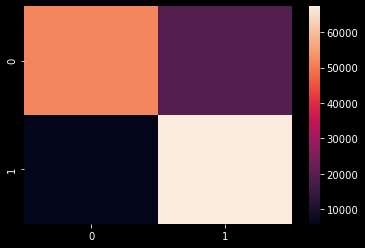

In [9]:
pred_step1 = model_step1.predict(X_val) # label predict
# pred_prob_step1 = model_step1.predict_proba(X_test) # prob predict
evaluate(y_val, pred_step1, ['foot', 'viecle'])

In [25]:
len(list(X_val))

32

Text(0.5, 0, 'Random Forest Feature Importance')

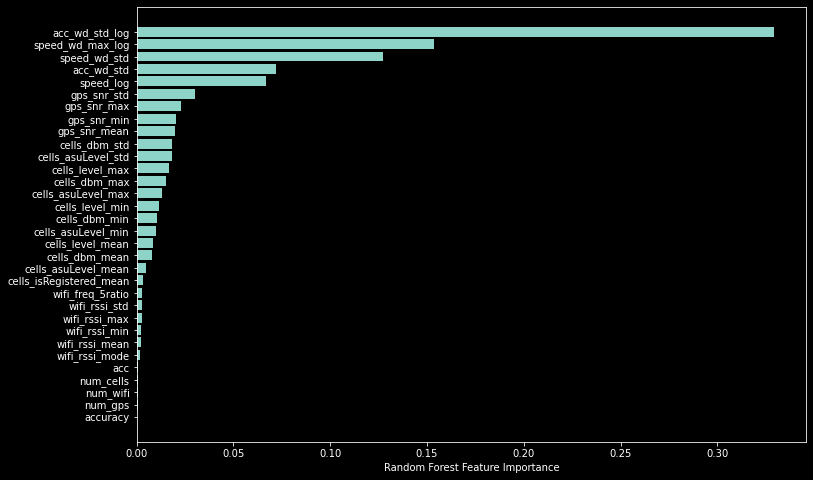

In [26]:
plt.figure(figsize = [12, 8])
sorted_idx = model_step1.feature_importances_.argsort()
plt.barh(list(X_val), model_step1.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

# Step2-1: Within Class 1

- differentiate {1: 'Still', 2: 'Walking', 3: 'Run', 4: 'Bike'}

In [10]:
test_ratio = 0.2
col_label = 'label'
X = data.df[data.df['label'] <= 4]
X_train, X_test, y_train, y_test = train_test_split(X.drop(col_drop + col_drop_x, axis = 1).fillna(0), X[col_label], test_size = test_ratio)
X_val, y_val = val.df[val.df['label'] <= 4].drop(col_drop + col_drop_x, axis = 1).fillna(0), val.df[val.df['label'] <= 4][col_label]

In [11]:
# train_data = lgb.Dataset(X_train, label = y_train - 1)
# test_data = lgb.Dataset(X_test, label = y_test - 1)
# params={
#     'learning_rate':0.1,
#     'lambda_l1':0.1,
#     'lambda_l2':0.2,
#     'max_depth':6,
#     'objective':'multiclass',
#     'num_class':8,  
# }
# model_step21 = lgb.train(params, train_data, valid_sets = [test_data])

model_step21 = RandomForestClassifier(n_estimators = 20, random_state = 0, max_depth = 8)
model_step21.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=20, random_state=0)

In [82]:
# pred_step21 = model_step21.predict(X_val).argmax(axis = 1)
pred_step21 = model_step21.predict(X_val)

[[24737  4937     2   160]
 [ 5343 19043   330  1433]
 [   27  1325   919   503]
 [  219  2094   920  8798]]
              precision    recall  f1-score   support

       Still       0.82      0.83      0.82     29836
     Walking       0.70      0.73      0.71     26149
         Run       0.42      0.33      0.37      2774
        Bike       0.81      0.73      0.77     12031

    accuracy                           0.76     70790
   macro avg       0.69      0.65      0.67     70790
weighted avg       0.75      0.76      0.75     70790



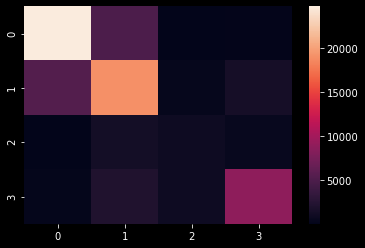

In [86]:
evaluate(y_val, pred_step21, list(label_dic.values())[:4])

# Step2-2: Within Class 1

- differentiate {5: 'Car', 6: 'Bus', 7: 'Train', 8: 'Subway'}

In [87]:
test_ratio = 0.2
col_label = 'label'
X = data.df[data.df['label'] > 4]
X_train, X_test, y_train, y_test = train_test_split(X.drop(col_drop + col_drop_x, axis = 1).fillna(0), X[col_label], test_size = test_ratio)
X_val, y_val = val.df[val.df['label'] > 4].drop(col_drop + col_drop_x, axis = 1).fillna(0), val.df[val.df['label'] > 4][col_label]

In [92]:
# train_data = lgb.Dataset(X_train, label = y_train - 5)
# test_data = lgb.Dataset(X_test, label = y_test - 5)
# params={
#     'learning_rate':0.1,
#     'lambda_l1':0.1,
#     'lambda_l2':0.2,
#     'max_depth':6,
#     'objective':'multiclass',
#     'num_class':8,  
# }
# model_step22 = lgb.train(params, train_data, valid_sets = [test_data])


model_step22 = RandomForestClassifier(n_estimators = 20, random_state = 0, max_depth = 8)
model_step22.fit(X_train, y_train-5)

RandomForestClassifier(max_depth=8, n_estimators=20, random_state=0)

In [94]:
# pred_step22 = model_step22.predict(X_val).argmax(axis = 1)
pred_step22 = model_step22.predict(X_val)

[[11089  4741  4231   412]
 [   87  6483   863  1745]
 [ 4442  1564 14395  1407]
 [ 2191   673  2878 15967]]
              precision    recall  f1-score   support

         Car       0.62      0.54      0.58     20473
         Bus       0.48      0.71      0.57      9178
       Train       0.64      0.66      0.65     21808
      Subway       0.82      0.74      0.77     21709

    accuracy                           0.66     73168
   macro avg       0.64      0.66      0.64     73168
weighted avg       0.67      0.66      0.66     73168



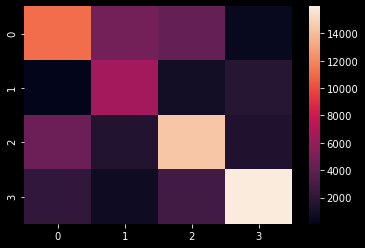

In [95]:
evaluate(y_val-5, pred_step22, list(label_dic.values())[4:])